# Clustering Titles with Theme Detection 

This notebook starts by reading in the data and quickly looking at the data quality. After, we vectorize the titles of the paper and run k-means clustering. The visual below is a t-SNE representation colored by each cluster. 

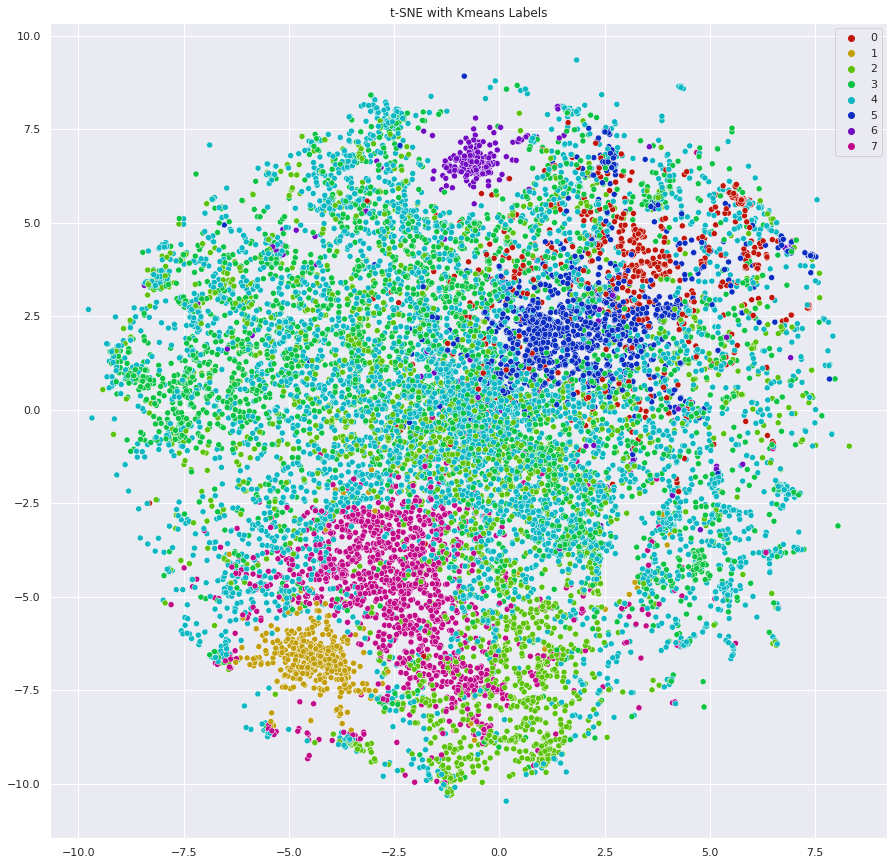

Last, we detect common themes in the clusters and save the file. 

## Read the Data

In [ ]:
#import our read and manipulation library 
import pandas as pd 

In [ ]:
df = pd.read_csv("../input/coleridgeinitiative-show-us-the-data/train.csv")
df.head()

In [ ]:
#inspect the dtypes
df.info()

In [ ]:
#feature engineering 
df['pub_title_count'] = df['pub_title'].apply(
    lambda x: len(x.strip().split()))  # word count in abstract
df.head()

In [ ]:
#remove possible duplicates
df.drop_duplicates(['pub_title'], inplace=True)
df['pub_title'].describe(include='all')

In [ ]:
#examine data
df.head(10)

In [ ]:
#drop NA's 
df.dropna(subset=['pub_title'],inplace=True)
df.info()

In [ ]:
df.isnull().sum()

In [ ]:
#subset and check the head one last time
df = df[['pub_title','pub_title_count']]
df.head()

## Cluster Analysis

### K-Means 

In [ ]:
#vectorize the data
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text,maxx_features):
    vectorizer = TfidfVectorizer(max_features = maxx_features)
    X = vectorizer.fit_transform(text)
    return X 

In [ ]:
#ensure search is converted to string, no punctuation and lower case 
df['pub_title']=df['pub_title'].astype(str)
df["pub_title"] = df['pub_title'].str.replace('[^\w\s]','')
df["pub_title"] = df['pub_title'].str.lower()
df.head(10)

In [ ]:
#tfid vectorize the column 
text = df['pub_title'].values
X = vectorize(text,2**12)
X.shape

In [ ]:
#PCA to reduce dimensions and k-means clustering 
from sklearn.decomposition import PCA 

pca = PCA(n_components=.95,random_state=42)
X_reduced = pca.fit_transform(X.toarray())
X_reduced.shape

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
from sklearn import metrics
import numpy as np
from scipy.spatial.distance import cdist 

distortions = []
K = range(2,20)

for k in K: 
    k_means = KMeans(n_clusters=k,random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced,k_means.cluster_centers_,'euclidean'),axis=1))/X.shape[0])

In [ ]:
import matplotlib.pyplot as plt 
X_line = [K[0],K[-1]]
Y_line = [distortions[0],distortions[-1]]

#plot the elbow 
plt.plot(K,distortions,'b-')
plt.plot(X_line,Y_line,'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method Showing Optimal K')
plt.show()

In [ ]:
k = 8
kmeans = KMeans(n_clusters = k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

In [ ]:
from sklearn.manifold import TSNE 

tsne = TSNE(verbose=1,perplexity=100,random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

In [ ]:
from matplotlib import pyplot as plt 
import seaborn as sns 

#sns settings
sns.set(rc={'figure.figsize':(15,15)})

#colors
palette = sns.color_palette("bright",1)

#plot
sns.scatterplot(X_embedded[:,0],X_embedded[:,1],palette=palette)
plt.title('t-SNE with no labels')
plt.savefig('t-sne_kmeans_academic')
plt.show()

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(k, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

## Detect Topics for each Cluster

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer 

In [ ]:
vectorizers = []

for i in range(0,k):
    vectorizers.append(CountVectorizer(min_df=5,max_df=.9,stop_words='english',lowercase=True))

In [ ]:
vectorized_data = []

for current_cluster,cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y']==current_cluster,'pub_title']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [ ]:
len(vectorized_data)

In [ ]:
num_topics_per_cluster = k 

lda_models = []
for i in range(0,k):
    lda = LatentDirichletAllocation(n_components = num_topics_per_cluster, max_iter = 10, learning_method = 'online',verbose=False,random_state=1)
    lda_models.append(lda)
    
lda_models[0]

In [ ]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

In [ ]:
def selected_topics(model,vectorizer,top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i],topic[i]) for i in topic.argsort()[:-top_n - 1:1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x:x[1])
    keywords.reverse()
    return_values = []
    for i in keywords:
        return_values.append(i[0])
    return return_values 

In [ ]:
all_keywords = []

for current_vectorizer,lda in enumerate(lda_models):
    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda,vectorizers[current_vectorizer]))

In [ ]:
all_keywords

### Add Clusters to Data 

In [ ]:
df['kmeans'] = y_pred

In [ ]:
df.to_csv("train_w_clusters.csv")